## Leveraging a pretrained model

Adapted from Chollet's [notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter08_intro-to-dl-for-computer-vision.ipynb) in accordance with the Apache V2 license.

See also [Keras Tutorial](https://keras.io/guides/transfer_learning/)

### Feature extraction with a pretrained model

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory

**Instantiating the VGG16 convolutional base**

**To the Student**: Read the VGG16 docs and check:
* What does `include_top=False` do? `
* What is the functionality of `input_shape` ?

In [2]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**To the Student**:
* Which layers does a conv block and a pool block each include?

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [5]:
# This should point to the small dataset of the Kaggle Dogs vs Cats competition that was created in a previous notebook
data_folder = pathlib.Path('../data/kaggle_dogs_vs_cats_small')

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Note: running the following cell on a CPU will take about 10 minutes

In [6]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 2s 2s/step


In [7]:
train_features.shape

(2000, 5, 5, 512)

These are 1000 images for each of the two classes, and then a 5x5 spatial matrix with a depth of 512 filters. 
**To the Student**: Compare these dimensions to the last layer of the VGG16 which generated it. 

Note that here we used VGG16 body as-is, without any additional training compared to the one done on imagenet. 

**Defining and training the densely connected classifier**

Here we define a new dense neural networks, of only two (neuronal/trainable) layers.

In [8]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 256)               3277056   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3,277,313
Trainable params: 3,277,313
Non-trainable params: 0
_________________________________________________________________


While the network has only two layer, its number of parameter is significant compared to the previous networks we defined to address the dogs versus cats dataset before (they had about 1 million paramters). It is also a significant ratio of the VGG16 body which has about 15 million parameters. This is common in CNNs - the feature vector can be quick large (here its sizze is 12800 elements). A dense layer linearly increases the number of parameters with its size. Then, the last layer further increases it linearly proportionally to the number of classes. 

In [10]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="./models/feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 29ms/step - loss: 20.4125 - accuracy: 0.9245 - val_loss: 7.1586 - val_accuracy: 0.9490
Epoch 2/20
63/63 [==============================] - 2s 26ms/step - loss: 4.0181 - accuracy: 0.9755 - val_loss: 4.6326 - val_accuracy: 0.9650
Epoch 3/20
63/63 [==============================] - 2s 24ms/step - loss: 2.9445 - accuracy: 0.9815 - val_loss: 12.5438 - val_accuracy: 0.9440
Epoch 4/20
63/63 [==============================] - 2s 25ms/step - loss: 1.3623 - accuracy: 0.9900 - val_loss: 4.7353 - val_accuracy: 0.9780
Epoch 5/20
63/63 [==============================] - 2s 25ms/step - loss: 0.3835 - accuracy: 0.9960 - val_loss: 5.6902 - val_accuracy: 0.9700
Epoch 6/20
63/63 [==============================] - 2s 28ms/step - loss: 0.9459 - accuracy: 0.9895 - val_loss: 5.3442 - val_accuracy: 0.9690
Epoch 7/20
63/63 [==============================] - 2s 25ms/step - loss: 0.5199 - accuracy: 0.9940 - val_loss: 6.6800 - val_accuracy: 0.9720
Epoch 8/20


**Plotting the results**

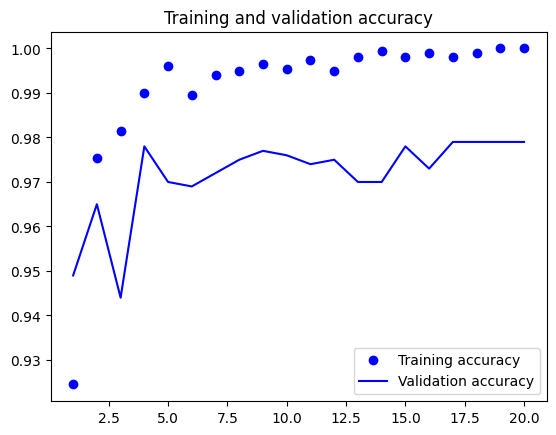

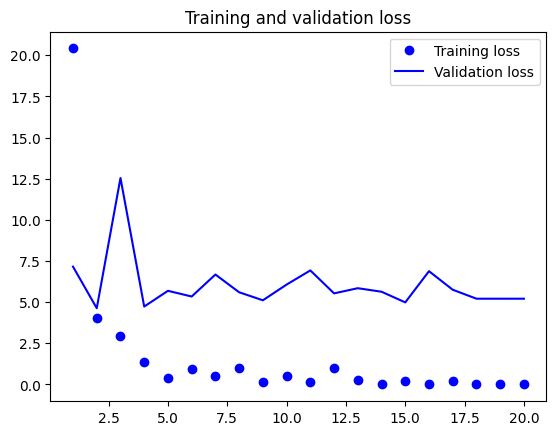

In [11]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [14]:
test_model = keras.models.load_model(
    "./models/feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(x=test_features, y=test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 4ms/step - loss: 5.8854 - accuracy: 0.9620
Test accuracy: 0.962


#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [22]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [23]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Printing the list of trainable weights before and after freezing**

The number of trainable weights after freezing the conv base:

In [32]:
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Adding a data augmentation stage and a classifier to the convolutional base**

**To the Student**: Check what the `preprocess_input` method does.

In [33]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [34]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_2 (Flatten)         (None, 12800)             0         
                                                           

Note: running the cell below will take about 3-4 hours on a CPU.

In [35]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 347s 6s/step - loss: 19.5388 - accuracy: 0.8930 - val_loss: 2.7956 - val_accuracy: 0.9740
Epoch 2/50
63/63 [==============================] - 341s 5s/step - loss: 6.1028 - accuracy: 0.9470 - val_loss: 2.7240 - val_accuracy: 0.9820
Epoch 3/50
63/63 [==============================] - 340s 5s/step - loss: 4.1450 - accuracy: 0.9605 - val_loss: 5.8096 - val_accuracy: 0.9730
Epoch 4/50
63/63 [==============================] - 368s 6s/step - loss: 6.5001 - accuracy: 0.9620 - val_loss: 4.5296 - val_accuracy: 0.9740
Epoch 5/50
63/63 [==============================] - 343s 5s/step - loss: 5.2252 - accuracy: 0.9585 - val_loss: 4.8635 - val_accuracy: 0.9700
Epoch 6/50
63/63 [==============================] - 327s 5s/step - loss: 5.3598 - accuracy: 0.9605 - val_loss: 5.1549 - val_accuracy: 0.9760
Epoch 7/50
63/63 [==============================] - 336s 5s/step - loss: 4.1430 - accuracy: 0.9720 - val_loss: 3.9013 - val_accuracy: 0.9770
Epoch 8/50
6

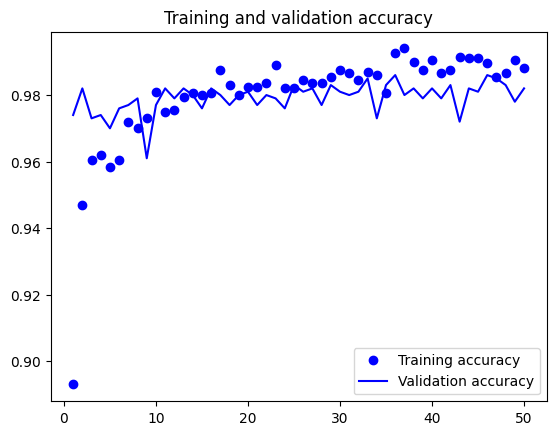

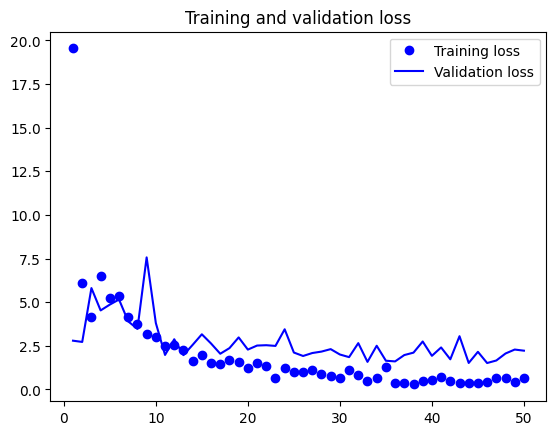

In [36]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [37]:
test_model = keras.models.load_model(
    "./models/feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 145s 2s/step - loss: 2.3313 - accuracy: 0.9750
Test accuracy: 0.975


### Fine-tuning a pretrained model

In [38]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [39]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [40]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_2 (Flatten)         (None, 12800)             0         
                                                           

**Fine-tuning the model**

Running the following cell on a CPU might take 4 hours.

In [41]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 388s 6s/step - loss: 0.6219 - accuracy: 0.9870 - val_loss: 1.4987 - val_accuracy: 0.9830
Epoch 2/30
63/63 [==============================] - 384s 6s/step - loss: 0.4389 - accuracy: 0.9885 - val_loss: 1.4816 - val_accuracy: 0.9850
Epoch 3/30
63/63 [==============================] - 385s 6s/step - loss: 0.2554 - accuracy: 0.9930 - val_loss: 2.4533 - val_accuracy: 0.9770
Epoch 4/30
63/63 [==============================] - 384s 6s/step - loss: 0.3393 - accuracy: 0.9905 - val_loss: 1.9685 - val_accuracy: 0.9830
Epoch 5/30
63/63 [==============================] - 427s 7s/step - loss: 0.4968 - accuracy: 0.9895 - val_loss: 1.8870 - val_accuracy: 0.9820
Epoch 6/30
63/63 [==============================] - 407s 6s/step - loss: 0.3325 - accuracy: 0.9920 - val_loss: 1.4735 - val_accuracy: 0.9820
Epoch 7/30
63/63 [==============================] - 404s 6s/step - loss: 0.2670 - accuracy: 0.9915 - val_loss: 1.4573 - val_accuracy: 0.9790
Epoch 8/30
63

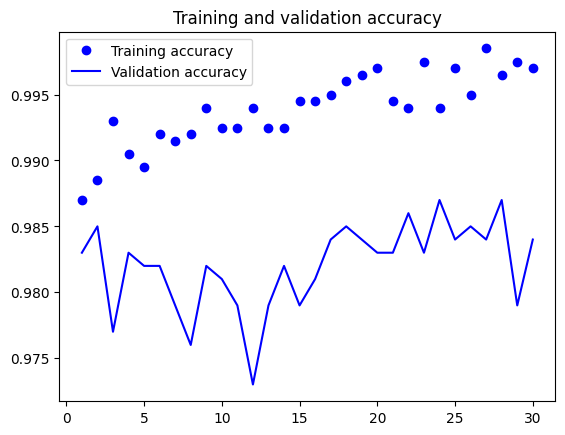

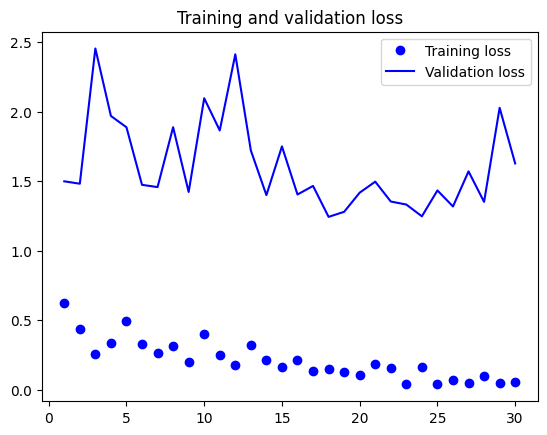

In [42]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [43]:
model = keras.models.load_model("./models/fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 232s 4s/step - loss: 1.6949 - accuracy: 0.9800
Test accuracy: 0.980
